<a href="https://colab.research.google.com/github/devdaveddev/Neonatal-EEG-seizure-recogniton-/blob/main/Neonatal%20EEG4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib as mp

In [2]:
!pip install scipy

In [3]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 43.9 MB/s eta 0:00:00


In [5]:
!pip install PyEMD


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 666.6/666.6 kB 7.4 MB/s eta 0:00:00


In [6]:
!pip install EMD-signal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.7
    Uninstalling dill-0.3.7:
      Successfully uninstalled dill-0.3.7
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.15
    Uninstalling multiprocess-0.70.15:
      Successfully uninstalled multiprocess-0.70.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.14.4 requires dill<0.3.8,>=0.3.0, but you have dill 0.4.0 which is incompatible.


Extracting EDF parameters from /content/eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipython-input-7-2338128130.py:7: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(edf_files[0], preload=True)


Reading 0 ... 299263  =      0.000 ...  1168.996 secs...
Using matplotlib as 2D backend.


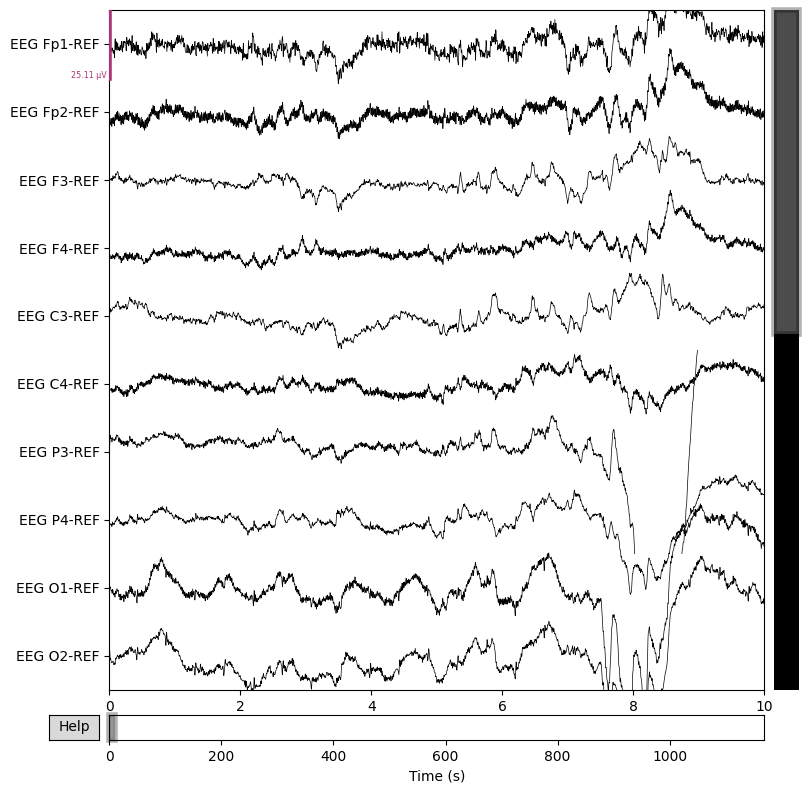

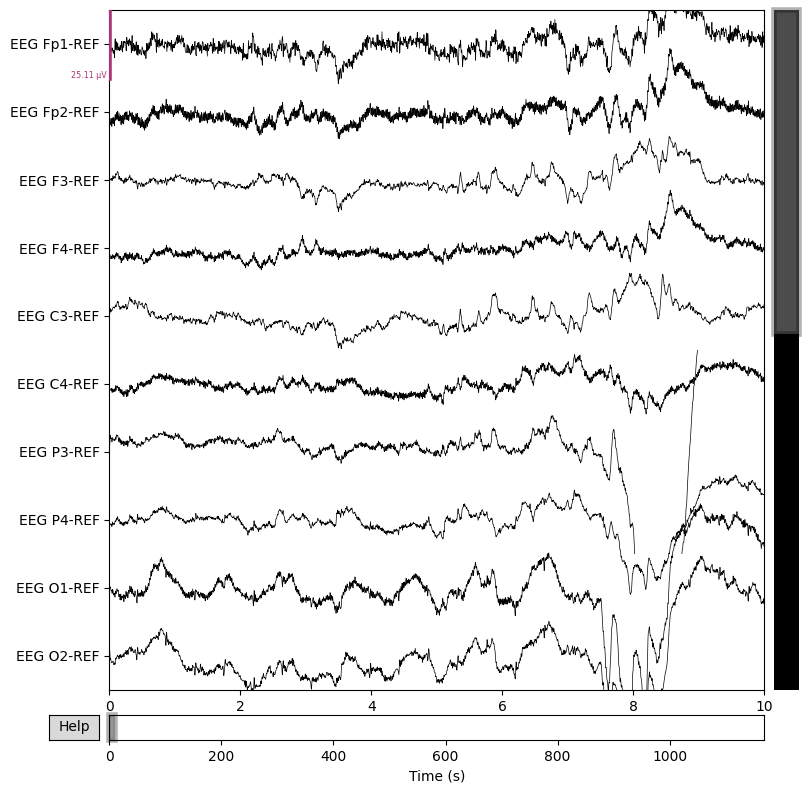

In [7]:
import mne
import matplotlib.pyplot as plt

edf_files = ['/content/eeg1.edf', '/content/eeg10.edf', '/content/eeg11.edf']


raw = mne.io.read_raw_edf(edf_files[0], preload=True)

raw.plot(scalings='auto', n_channels=10, duration=10, title='Raw EEG')


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.5s finished


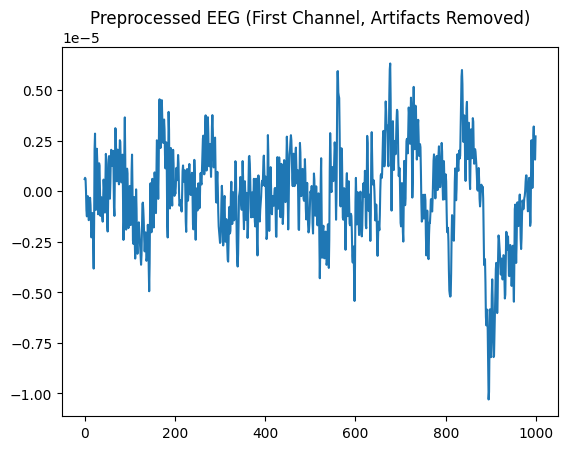

In [8]:
from scipy.signal import butter, filtfilt
import numpy as np
import matplotlib.pyplot as plt

#  raw EEG data and sampling frequency
data, times = raw[:]
sfreq = raw.info['sfreq']

# Bandpass filter function (0.5 - 70 Hz)
def bandpass_filter(signal, lowcut=0.5, highcut=70, fs=sfreq, order=4):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)


filtered_data = [bandpass_filter(ch_data) for ch_data in data]


raw.notch_filter(freqs=50)


def remove_artifacts(signal, z_thresh=3.0):
    mean = np.mean(signal)
    std = np.std(signal)
    z_scores = (signal - mean) / std

    clean_signal = np.where(np.abs(z_scores) > z_thresh, mean, signal)
    return clean_signal

# Apply artifact removal to all filtered channels
artifact_removed_data = [remove_artifacts(ch_data) for ch_data in filtered_data]


preprocessed_data = artifact_removed_data


plt.plot(preprocessed_data[0][:1000])
plt.title("Preprocessed EEG (First Channel, Artifacts Removed)")
plt.show()


/tmp/ipython-input-12-3874676031.py:17: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


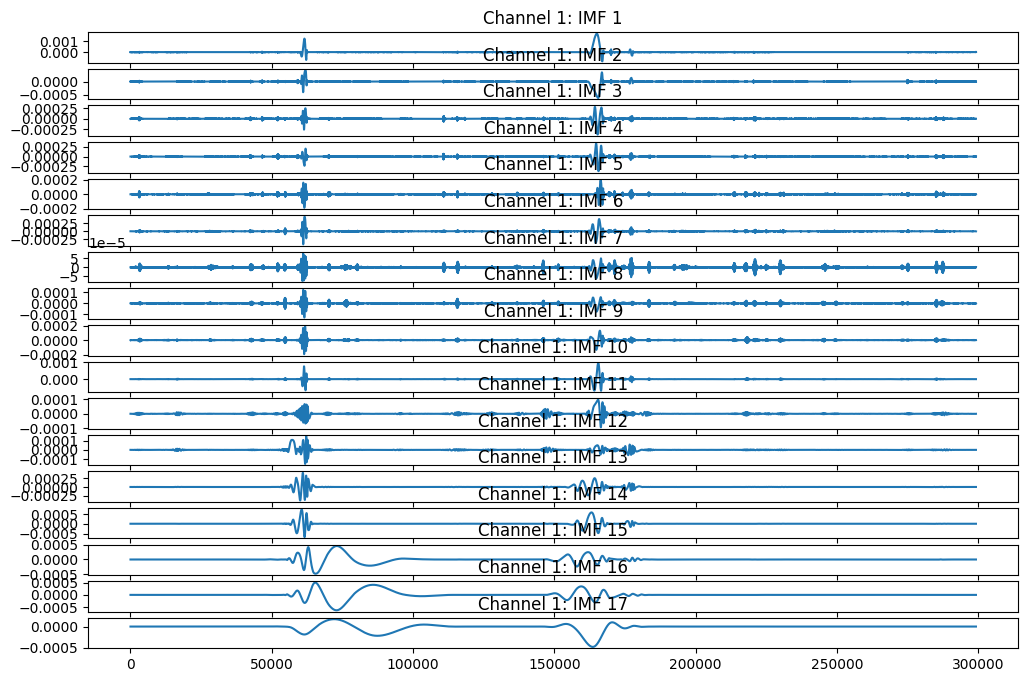

/tmp/ipython-input-12-3874676031.py:17: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


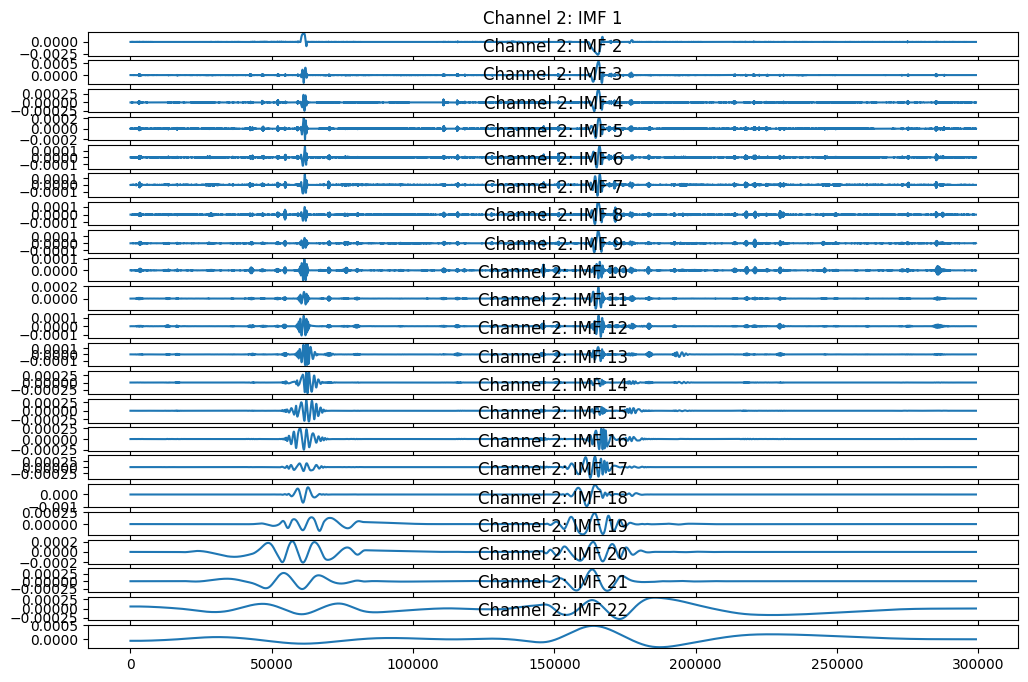

/tmp/ipython-input-12-3874676031.py:17: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


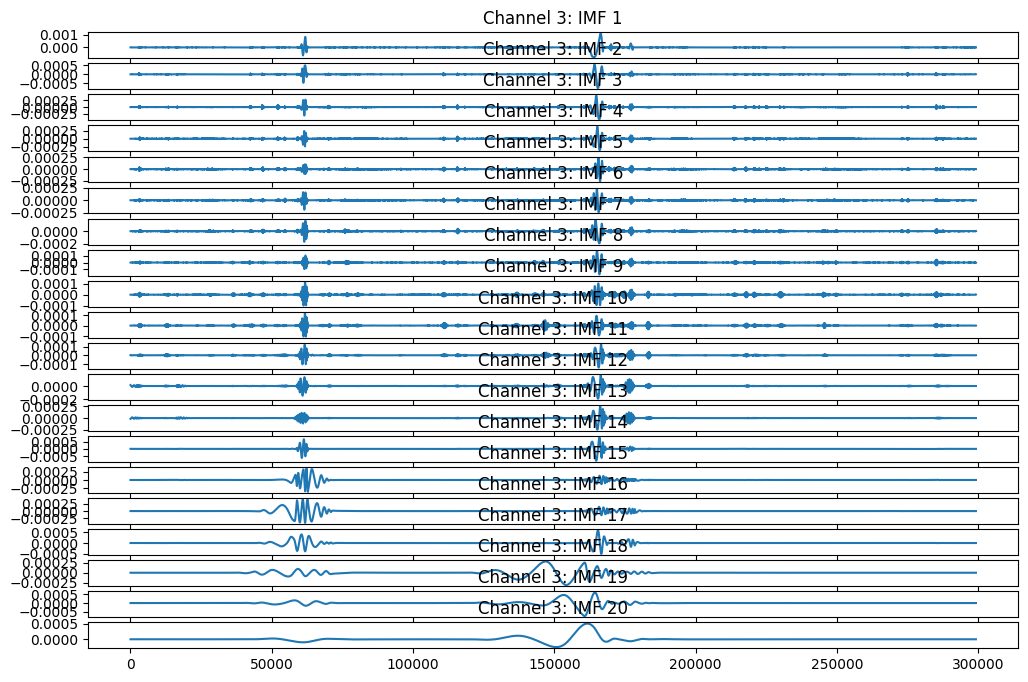

In [ ]:
from PyEMD import EMD

emd = EMD()
all_channel_imfs = []  # To store IMFs of all channels

# Decompose each channel
for ch_idx, channel_data in enumerate(filtered_data):
    imfs = emd(channel_data)
    all_channel_imfs.append(imfs)

    # Plot IMFs for this channel
    plt.figure(figsize=(12, 8))
    for i, imf in enumerate(imfs):
        plt.subplot(len(imfs), 1, i + 1)
        plt.plot(imf)
        plt.title(f'Channel {ch_idx + 1}: IMF {i + 1}')
    plt.tight_layout()
    plt.show()

# Example: Access IMFs for first channel
imfs_channel_1 = all_channel_imfs[0]
